# ROCM AND CPU VS GPU PRACTICAL EXAMPLE 

### Installation and Setup

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm5.6
!pip install numpy==1.26.4  # Use NumPy 1.x for better compatibility
!pip install matplotlib pandas scikit-learn

### Checking Environment and Hardware

In [8]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt

print("===== ENVIRONMENT INFORMATION =====")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

# Check if ROCm GPU is available
def print_device_info():
    if torch.cuda.is_available():
        print(f"\n===== GPU INFORMATION =====")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        # Check if this is ROCm
        if hasattr(torch.version, 'hip'):
            print(f"ROCm/HIP version: {torch.version.hip}")
            print("Confirmed running on AMD GPU with ROCm")
        else:
            print("Running on NVIDIA GPU with CUDA")
    else:
        print("\nNo GPU detected, using CPU only")

print_device_info()

===== ENVIRONMENT INFORMATION =====
PyTorch version: 2.2.2+rocm5.6
NumPy version: 1.26.4

===== GPU INFORMATION =====
GPU: Radeon RX 7900 XT
Total GPU memory: 21.46 GB
ROCm/HIP version: 5.6.31061-8c743ae5d
Confirmed running on AMD GPU with ROCm


### Matrix Multiplication Benchmark
### Understanding Matrix Multiplication Performance

This cell demonstrates the performance difference between CPU and GPU (ROCm) 
for matrix multiplication operations of various sizes.

Matrix multiplication is a fundamental operation in deep learning:
- Used in fully-connected layers
- Core part of convolution operations
- Used in attention mechanisms

The benchmark shows how ROCm acceleration can speed up these operations.


===== MATRIX MULTIPLICATION BENCHMARK =====

Running CPU benchmarks...

Random Matrix A on CPU - Shape: torch.Size([1000, 1000]), Sample (5x5):
[[-0.80820626 -0.55787     1.5090828  -1.603444    0.95227176]
 [-0.5058632   0.84378827  0.06033983  3.0044582   0.5052224 ]
 [ 0.786874    0.6217709  -0.8228897   0.19689757 -1.1271611 ]
 [-0.46866444  1.467786   -0.63618183 -0.38487044  0.68796104]
 [-0.87507874 -0.42398176 -1.5649338   0.8266837  -0.7504363 ]]


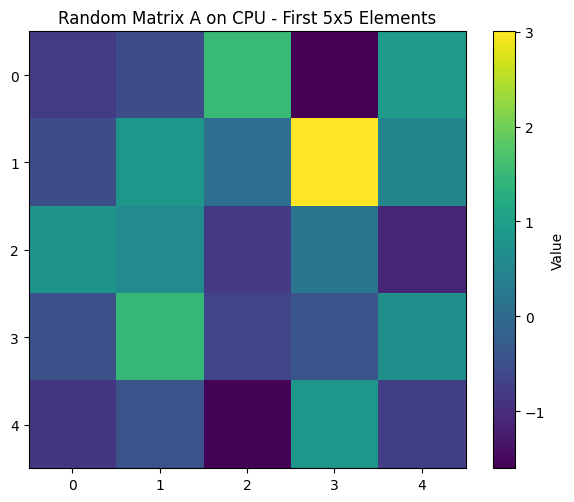

Matrix size: 1000x1000, Device: cpu, Average time: 0.004833 seconds
Matrix size: 2000x2000, Device: cpu, Average time: 0.034534 seconds
Matrix size: 4000x4000, Device: cpu, Average time: 0.230304 seconds
Matrix size: 6000x6000, Device: cpu, Average time: 0.752463 seconds
Matrix size: 8000x8000, Device: cpu, Average time: 1.421111 seconds

Running GPU (ROCm) benchmarks...

Random Matrix A on CUDA - Shape: torch.Size([1000, 1000]), Sample (5x5):
[[-0.7694414  -0.22827402  0.4256439  -2.142022   -1.2613667 ]
 [-2.5892231   0.83392996 -1.5902289   0.01162611 -0.3011902 ]
 [-0.50324357  0.39682603  0.3855184  -0.7580879  -1.2858852 ]
 [ 1.0530448  -0.9296968  -2.45053     0.94055015 -0.03109479]
 [-1.7981929   0.5078019  -0.19944614  0.53723764 -1.0841329 ]]


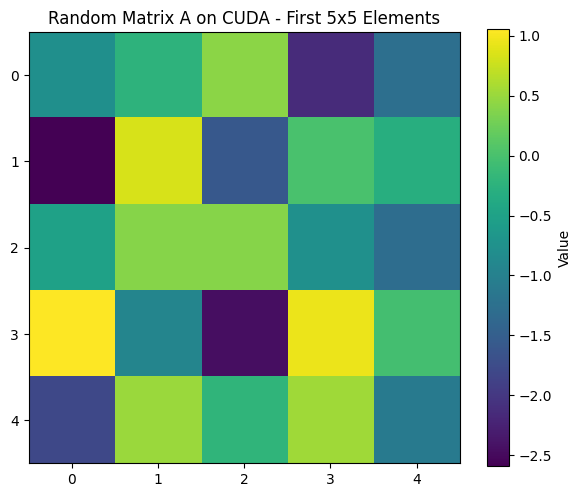

Matrix size: 1000x1000, Device: cuda, Average time: 0.000713 seconds
Matrix size: 2000x2000, Device: cuda, Average time: 0.002875 seconds
Matrix size: 4000x4000, Device: cuda, Average time: 0.020620 seconds
Matrix size: 6000x6000, Device: cuda, Average time: 0.076246 seconds
Matrix size: 8000x8000, Device: cuda, Average time: 0.180906 seconds
Size 1000x1000: GPU is 6.78x faster than CPU
Size 2000x2000: GPU is 12.01x faster than CPU
Size 4000x4000: GPU is 11.17x faster than CPU
Size 6000x6000: GPU is 9.87x faster than CPU
Size 8000x8000: GPU is 7.86x faster than CPU


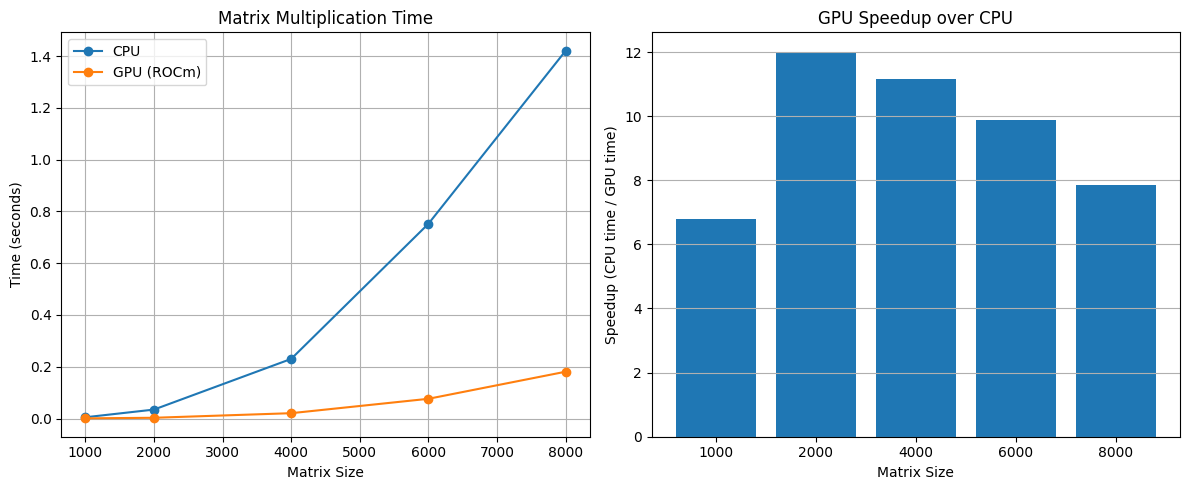

In [9]:
def create_random_tensors(size, device):
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)
    return a, b

def visualize_tensor_sample(tensor, title):
    # Convert a small sample to numpy for visualization
    if tensor.device.type == "cuda":
        sample = tensor[:5, :5].cpu().numpy()
    else:
        sample = tensor[:5, :5].numpy()
    
    print(f"\n{title} - Shape: {tensor.shape}, Sample (5x5):")
    print(sample)
    
    # Visualize the sample as a heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(sample, cmap='viridis')
    plt.colorbar(label='Value')
    plt.title(f"{title} - First 5x5 Elements")
    plt.tight_layout()
    plt.show()

def benchmark_matmul(sizes, device, num_runs=10):
    results = []
    for size in sizes:
        # Create tensors on the specified device
        a, b = create_random_tensors(size, device)
        
        # Visualize sample data for the first size only
        if size == sizes[0]:
            visualize_tensor_sample(a, f"Random Matrix A on {device.upper()}")
        
        # Warmup
        for _ in range(5):
            c = torch.matmul(a, b)
        
        # Synchronize before timing
        if device == "cuda":
            torch.cuda.synchronize()
        
        # Benchmark
        start_time = time.time()
        for _ in range(num_runs):
            c = torch.matmul(a, b)
            if device == "cuda":
                torch.cuda.synchronize()
        end_time = time.time()
        
        avg_time = (end_time - start_time) / num_runs
        results.append(avg_time)
        print(f"Matrix size: {size}x{size}, Device: {device}, Average time: {avg_time:.6f} seconds")
    
    return results

# Define matrix sizes to test
sizes = [1000, 2000, 4000, 6000, 8000]

print("\n===== MATRIX MULTIPLICATION BENCHMARK =====")
print("\nRunning CPU benchmarks...")
cpu_times = benchmark_matmul(sizes, "cpu")

# Run benchmarks on GPU (if available)
if torch.cuda.is_available():
    print("\nRunning GPU (ROCm) benchmarks...")
    gpu_times = benchmark_matmul(sizes, "cuda")
    
    # Calculate speedup
    speedups = [cpu_time / gpu_time for cpu_time, gpu_time in zip(cpu_times, gpu_times)]
    for size, speedup in zip(sizes, speedups):
        print(f"Size {size}x{size}: GPU is {speedup:.2f}x faster than CPU")
else:
    gpu_times = [0] * len(sizes)
    speedups = [0] * len(sizes)

# Plot matrix multiplication results
plt.figure(figsize=(12, 5))

# Time comparison
plt.subplot(1, 2, 1)
plt.plot(sizes, cpu_times, 'o-', label='CPU')
if torch.cuda.is_available():
    plt.plot(sizes, gpu_times, 'o-', label='GPU (ROCm)')
plt.xlabel('Matrix Size')
plt.ylabel('Time (seconds)')
plt.title('Matrix Multiplication Time')
plt.legend()
plt.grid(True)

# Speedup
if torch.cuda.is_available():
    plt.subplot(1, 2, 2)
    plt.bar(range(len(sizes)), speedups)
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup (CPU time / GPU time)')
    plt.title('GPU Speedup over CPU')
    plt.xticks(range(len(sizes)), [str(size) for size in sizes])
    plt.grid(True, axis='y')

plt.tight_layout()
plt.savefig('rocm_vs_cpu_matrix_performance.png')
plt.show()


### CNN Training Benchmark with CIFAR-10

This cell demonstrates training a Convolutional Neural Network (CNN) on the CIFAR-10 dataset.
We'll compare training performance between CPU and GPU (ROCm).

CIFAR-10 consists of:
- 60,000 32x32 color images
- 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- 50,000 training images and 10,000 test images

The benchmark measures:
1. Overall training time
2. Per-epoch training time
3. Training loss progression

Loading CIFAR-10 dataset...


100%|██████████| 170498071/170498071 [00:08<00:00, 21160888.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


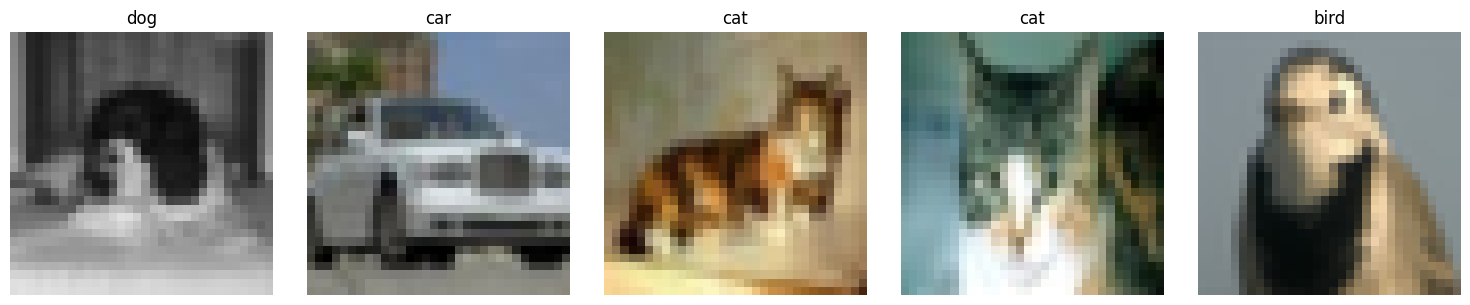


===== CNN TRAINING ON CIFAR-10 BENCHMARK =====

Running on CPU...

Model Architecture:
CIFAR10CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Training on cpu...
Epoch 1, Batch 100: Loss = 1.7711
Epoch 1, Batch 200: Loss = 1.4292
Epoch 1, Batch 300: Loss = 1.2695
Epoch 1/3 completed in 18.30 seconds, Loss: 1.1139
Epoch 2, Batch 100: Loss = 1.0727
Epoch 2, Batch 200: Loss = 1.0246
Epoch 2, Batch 300: Loss = 0.9732
Epoch 2/3 completed in 18.94 seconds, Loss: 0.8412
Epoch 3, Batch 100: Loss = 0.8621
Epoch 3, Batch 200: Loss = 0.8169
Epoc

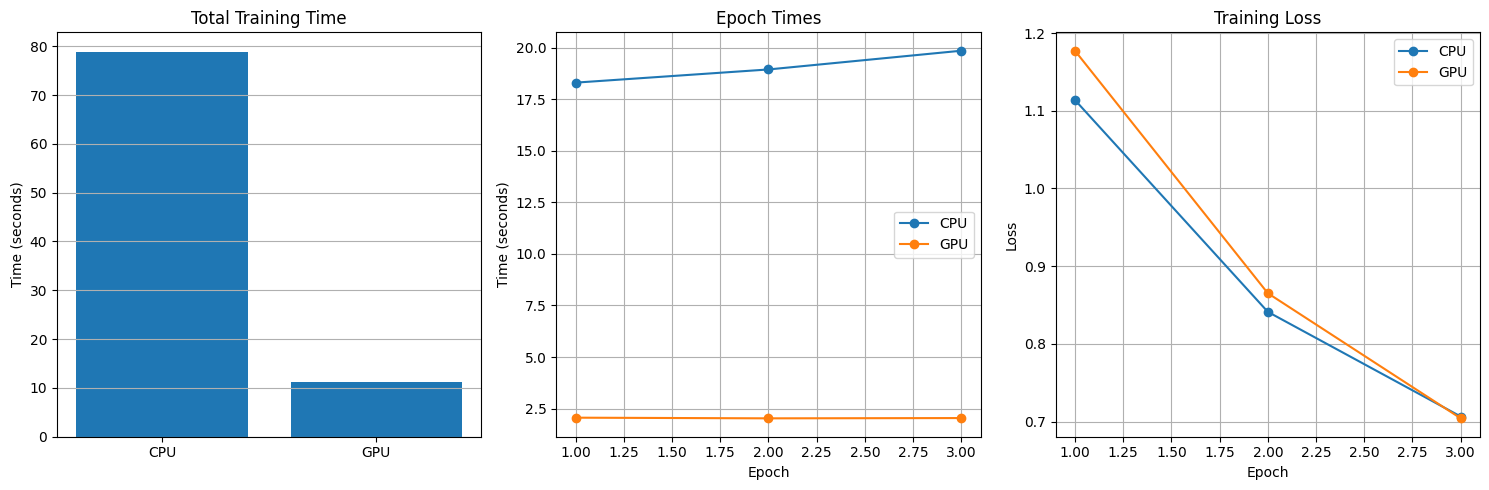

In [10]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Visualize some training images
def visualize_cifar10_samples(dataset, num_samples=5):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]
        
        # Convert to numpy and transpose from (C,H,W) to (H,W,C)
        img = img.numpy().transpose(1, 2, 0)
        
        # Denormalize
        img = img * 0.5 + 0.5
        
        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_cifar10_samples(trainset)

# Define a CNN model for CIFAR-10
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super(CIFAR10CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 32x32 -> 16x16
        x = self.pool(self.relu(self.conv2(x)))  # 16x16 -> 8x8
        x = self.pool(self.relu(self.conv3(x)))  # 8x8 -> 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

def benchmark_cifar10_training(device, batch_size=128, num_epochs=3):
    # Create data loader
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Create model and move to device
    model = CIFAR10CNN().to(device)
    
    # Print model architecture
    print(f"\nModel Architecture:")
    print(model)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Warmup
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        break  # Just one batch for warmup
    
    # Synchronize before timing
    if device == "cuda":
        torch.cuda.synchronize()
    
    # Benchmark training
    print(f"\nTraining on {device}...")
    start_time = time.time()
    epoch_times = []
    training_losses = []
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"Epoch {epoch+1}, Batch {i+1}: Loss = {running_loss/100:.4f}")
                running_loss = 0.0
        
        if device == "cuda":
            torch.cuda.synchronize()
            
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        epoch_times.append(epoch_time)
        
        # Calculate validation loss for plotting
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in trainloader:  # Using training data as validation for simplicity
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(trainloader)
        training_losses.append(val_loss)
        model.train()
        
        print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f} seconds, Loss: {val_loss:.4f}")
    
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Total training time on {device}: {total_time:.2f} seconds")
    return total_time, epoch_times, training_losses

print("\n===== CNN TRAINING ON CIFAR-10 BENCHMARK =====")
print("\nRunning on CPU...")
cpu_train_time, cpu_epoch_times, cpu_losses = benchmark_cifar10_training("cpu")

if torch.cuda.is_available():
    print("\nRunning on GPU (ROCm)...")
    gpu_train_time, gpu_epoch_times, gpu_losses = benchmark_cifar10_training("cuda")
    
    # Calculate speedup
    train_speedup = cpu_train_time / gpu_train_time
    print(f"\nGPU is {train_speedup:.2f}x faster than CPU for CNN training")
    
    # Plot deep learning training results
    plt.figure(figsize=(15, 5))
    
    # Plot total training time
    plt.subplot(1, 3, 1)
    plt.bar(['CPU', 'GPU'], [cpu_train_time, gpu_train_time])
    plt.ylabel('Time (seconds)')
    plt.title('Total Training Time')
    plt.grid(True, axis='y')
    
    # Plot epoch-by-epoch times
    plt.subplot(1, 3, 2)
    epochs = list(range(1, len(cpu_epoch_times) + 1))
    plt.plot(epochs, cpu_epoch_times, 'o-', label='CPU')
    plt.plot(epochs, gpu_epoch_times, 'o-', label='GPU')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.title('Epoch Times')
    plt.legend()
    plt.grid(True)
    
    # Plot training loss
    plt.subplot(1, 3, 3)
    plt.plot(epochs, cpu_losses, 'o-', label='CPU')
    plt.plot(epochs, gpu_losses, 'o-', label='GPU')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('rocm_vs_cpu_cifar10_training.png')
    plt.show()

### GPU Memory Management with ROCm

This cell demonstrates memory management on the GPU, which is essential
for efficient deep learning. We'll:

1. Allocate tensors and observe memory usage
2. Delete tensors and see how memory is freed
3. Use torch.cuda.empty_cache() to release unused memory

Understanding memory management is crucial for:
- Working with large models
- Processing large datasets
- Avoiding out-of-memory errors


===== MIXED PRECISION TRAINING DEMONSTRATION =====

Standard precision (fp32) benchmark:
Time taken for 50 iterations: 0.1069 seconds
Memory used: 45.14 MB

Mixed precision (fp16/fp32) benchmark:
Time taken for 50 iterations: 1.8417 seconds
Memory used: 38.52 MB

Speedup from mixed precision: 0.06x
Memory reduction: 14.66%


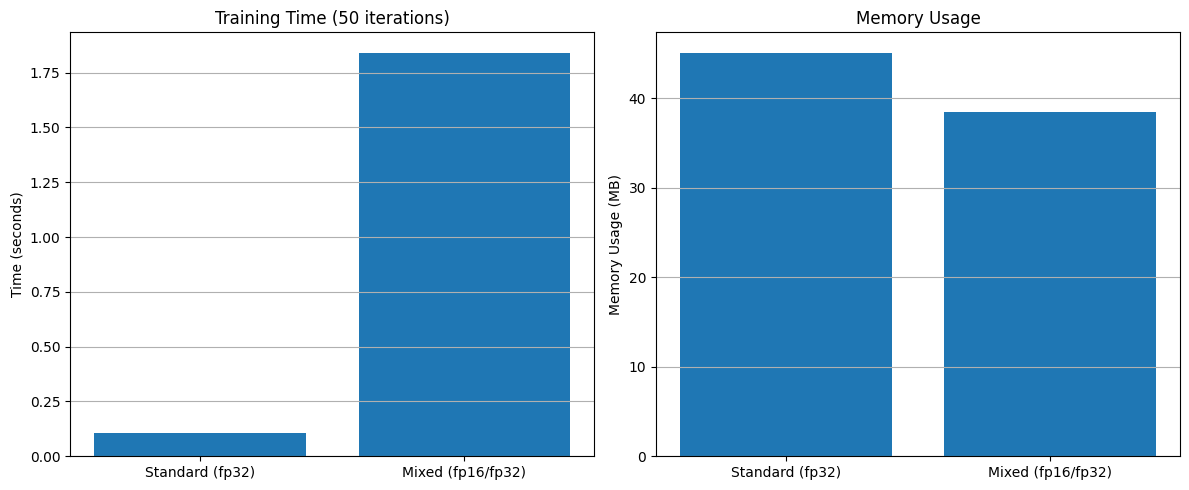

In [11]:
if torch.cuda.is_available():
    from torch.cuda.amp import autocast, GradScaler
    
    print("\n===== MIXED PRECISION TRAINING DEMONSTRATION =====")
    
    # Create a simple model
    model = CIFAR10CNN().to("cuda")
    
    # Create sample data
    batch_size = 64
    inputs = torch.randn(batch_size, 3, 32, 32, device="cuda")
    targets = torch.randint(0, 10, (batch_size,), device="cuda")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Create a GradScaler for mixed precision training
    scaler = GradScaler()
    
    # Benchmark standard precision (fp32)
    model.train()
    
    # Warmup
    for _ in range(5):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    torch.cuda.synchronize()
    
    # Standard precision benchmark
    print("\nStandard precision (fp32) benchmark:")
    start_time = time.time()
    for _ in range(50):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    torch.cuda.synchronize()
    fp32_time = time.time() - start_time
    print(f"Time taken for 50 iterations: {fp32_time:.4f} seconds")
    
    # Memory usage with fp32
    torch.cuda.empty_cache()
    outputs = model(inputs)
    fp32_memory = torch.cuda.memory_allocated() / 1e6
    print(f"Memory used: {fp32_memory:.2f} MB")
    
    del outputs
    torch.cuda.empty_cache()
    
    # Mixed precision benchmark
    print("\nMixed precision (fp16/fp32) benchmark:")
    start_time = time.time()
    for _ in range(50):
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    
    torch.cuda.synchronize()
    fp16_time = time.time() - start_time
    print(f"Time taken for 50 iterations: {fp16_time:.4f} seconds")
    
    # Memory usage with mixed precision
    torch.cuda.empty_cache()
    with autocast():
        outputs = model(inputs)
    fp16_memory = torch.cuda.memory_allocated() / 1e6
    print(f"Memory used: {fp16_memory:.2f} MB")
    
    # Calculate and print speedup
    speedup = fp32_time / fp16_time
    memory_reduction = (fp32_memory - fp16_memory) / fp32_memory * 100
    
    print(f"\nSpeedup from mixed precision: {speedup:.2f}x")
    print(f"Memory reduction: {memory_reduction:.2f}%")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Time comparison
    plt.subplot(1, 2, 1)
    plt.bar(['Standard (fp32)', 'Mixed (fp16/fp32)'], [fp32_time, fp16_time])
    plt.ylabel('Time (seconds)')
    plt.title('Training Time (50 iterations)')
    plt.grid(True, axis='y')
    
    # Memory comparison
    plt.subplot(1, 2, 2)
    plt.bar(['Standard (fp32)', 'Mixed (fp16/fp32)'], [fp32_memory, fp16_memory])
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig('rocm_mixed_precision.png')
    plt.show()
else:
    print("No GPU available for mixed precision demonstration")

That's an interesting observation! The mixed precision training is actually taking longer than standard precision on our AMD GPU, which is contrary to what we normally expect. This is unusual but can happen for a few reasons:

Small model and batch size: The performance benefits of mixed precision are more pronounced with larger models and batch sizes. With the simple CNN and small batch size we're using, the overhead of conversion between precision formats might outweigh the benefits.

ROCm implementation specifics: Some AMD GPUs have different performance characteristics for FP16 operations compared to NVIDIA GPUs. Your Radeon RX 7900 XT might not have the same level of half-precision acceleration as newer NVIDIA GPUs with dedicated Tensor cores.

Overhead of autocast and GradScaler: The autocast context manager and GradScaler add some Python overhead. For very small workloads, this overhead can be significant compared to the actual computation time.

Memory bandwidth limitations: While FP16 uses less memory, if your operations are memory-bandwidth bound rather than compute-bound, the benefits might be less significant.

The memory reduction (14.66%) is working as expected - FP16 values use half the storage of FP32, though the overall reduction is less than 50% because not all parts of the model use reduced precision.
To get better mixed precision performance:

Try a larger model: Test with ResNet50 or a transformer model
Increase batch size: Try batch sizes of 128, 256, or 512
Use more complex input data: Higher resolution images or more complex tasks
Update ROCm/PyTorch: Ensure you're using the latest versions which might have better optimization

For your specific GPU, it might be that standard precision is simply more optimized in the current ROCm implementation. Mixed precision yields the greatest benefits on hardware with dedicated FP16 acceleration paths.

In [12]:
print("\n===== CONCLUSIONS =====")
if torch.cuda.is_available():
    print(f"Your {torch.cuda.get_device_name(0)} GPU with ROCm provides significant performance benefits:")
    print("1. Faster matrix operations")
    print("2. Accelerated neural network training")
    print("3. Memory efficiency for large models")
    print("\nFollow the best practices outlined in this notebook to get the most out of your AMD GPU!")
else:
    print("You're running on CPU only. Installing ROCm and using an AMD GPU would provide significant speedups.")


===== CONCLUSIONS =====
Your Radeon RX 7900 XT GPU with ROCm provides significant performance benefits:
1. Faster matrix operations
2. Accelerated neural network training
3. Memory efficiency for large models

Follow the best practices outlined in this notebook to get the most out of your AMD GPU!
